In [1]:
import clrs
import jax
import numpy as np

rng = np.random.RandomState(42)
rng_key = jax.random.PRNGKey(rng.randint(2**32, dtype=np.int64))
NUM_SAMPLES = 1000

# Create samplers
sampler, spec = clrs.build_sampler(
        "bellman_ford",
        seed=rng.randint(2**32, dtype=np.int64),
        num_samples=NUM_SAMPLES,
        length=7,
        )
# batch_size = feedback.outputs[0].data.shape[0]
# new_rng_key, rng_key = jax.random.split(rng_key)


2025-03-09 17:57:47.366612: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741543067.377468   54531 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741543067.380939   54531 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [11]:
from clrs._src.algorithms.graphs import bfs

feedback = sampler.next()
import random
item = random.randint(1, NUM_SAMPLES) - 1
weights = feedback.features.inputs[2].data[item]
adj = feedback.features.inputs[3].data[item]
start_node = feedback.features.inputs[1].data[item].argmax()
bfs_res =bfs(adj, start_node)

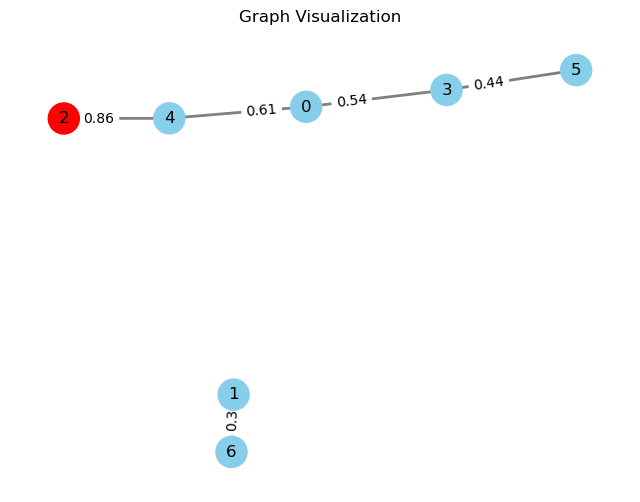

In [12]:
from interp.visualisation import visualize_graph_from_adjacency_matrix

visualize_graph_from_adjacency_matrix(adj, weights, start_node)

In [45]:
from clrs._src import probing
from clrs._src.specs import SPECS

bfs_spec = SPECS['bfs']
inp, outp, hint = probing.split_stages(bfs_res[1], bfs_spec)

In [46]:
inp

[DataPoint(name="pos",	location=node,	type=scalar,	data=Array(1, 7)),
 DataPoint(name="s",	location=node,	type=mask_one,	data=Array(1, 7)),
 DataPoint(name="A",	location=edge,	type=scalar,	data=Array(1, 7, 7)),
 DataPoint(name="adj",	location=edge,	type=mask,	data=Array(1, 7, 7))]

In [44]:
bfs_res

(array([4, 1, 2, 0, 2, 3, 6]),
 {'input': {'node': {'pos': {'data': array([0.        , 0.14285714, 0.28571429, 0.42857143, 0.57142857,
            0.71428571, 0.85714286]),
     'type_': 'scalar'},
    's': {'data': array([0., 0., 1., 0., 0., 0., 0.]), 'type_': 'mask_one'}},
   'edge': {'A': {'data': array([[1., 0., 0., 1., 1., 0., 0.],
            [0., 1., 0., 0., 0., 0., 1.],
            [0., 0., 1., 0., 1., 0., 0.],
            [1., 0., 0., 1., 0., 1., 0.],
            [1., 0., 1., 0., 1., 0., 0.],
            [0., 0., 0., 1., 0., 1., 0.],
            [0., 1., 0., 0., 0., 0., 1.]]),
     'type_': 'scalar'},
    'adj': {'data': array([[1., 0., 0., 1., 1., 0., 0.],
            [0., 1., 0., 0., 0., 0., 1.],
            [0., 0., 1., 0., 1., 0., 0.],
            [1., 0., 0., 1., 0., 1., 0.],
            [1., 0., 1., 0., 1., 0., 0.],
            [0., 0., 0., 1., 0., 1., 0.],
            [0., 1., 0., 0., 0., 0., 1.]]),
     'type_': 'mask'}},
   'graph': {}},
  'output': {'node': {'pi': {'

In [38]:
feedback.features.inputs[3].data[item] == bfs_res[1]['input']['edge']['adj']['data']

array([[ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True]])